# Module 2 Final Project
* Student: Emily J. Cain
* Date: December 2018
* Instructor: Rafael Carrasco

## Hypothesis 1
* H0 - Discount amount does not have a statistically significant effect on the quantity of the product ordered.
* H1 - Discount amount has a statistically significant effect on the quantity of the product ordered.

### Further Questions
* At what level(s) of discount? (Requirement)
* Does original unit price also have an effect? (Me)

## Hypothesis 2
* H0 - The top employee does not sell more in dollars than the average employee.
* H2 - The top employee sells more in dollars than the average employee.

## Hypothesis 3
* H0 - No product sells significantly better in quantity than the other products. 
* H3 - At least one product sells significantly better in quantity than the other products.  

## Hypothesis 4
* H0 -
* H4 - 

## Ideas
* Does the database show how long a customer has been with the company? Does customer loyalty have an effect on orders? Actionable - target specific customers
* Certain products and their sales - is there a product more popular in a certain regions where we could use targeted advertising? 
* Are there employees with a much higher sales rate than others? Maybe there should be a bonus for making a certain amount of sales. Possibly sort by region?
* What are the most popular products? What about offering sales on certain products - OR! Offering a discount on the products that are _already_ popular if they buy something else or spend a certain amount of money?? Ooohhh. But this doesn't count as a random sample?
* Are certain products always bought together? Is this something I can even figure out lol?
* Top customers?

In [1]:
# Notes to myself
# Active or passive tone when talking about rejecting the null hypothesis? Be consistent throughout.
# Be able to describe: log transformation, t-value, critical t-value
# Choose consistent color themes
# Show visualization of where the mean falls on the curve - do you need to divide your p-value by 2? Yes probably
# Be consistent with rounding

## Establish connection to the database

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

## Grab table names

In [4]:
c.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

## Create dataframes of each table for initial inspection

In [5]:
employee_df = pd.read_sql_query('SELECT * FROM Employee;', conn)
employee_df.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [6]:
category_df = pd.read_sql_query('SELECT * FROM Category;', conn)
category_df.head()

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


In [81]:
customer_df = pd.read_sql_query('SELECT * FROM Customer;', conn)
customer_df.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [8]:
shipper_df = pd.read_sql_query('SELECT * FROM Shipper;', conn)
shipper_df.head()

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [9]:
supplier_df = pd.read_sql_query('SELECT * FROM Supplier;', conn)
supplier_df.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


Use square brackets when querying ```[Order]``` due to being a reserved keyword 

In [10]:
order_df = pd.read_sql_query('SELECT * FROM [Order];', conn)
order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [11]:
product_df = pd.read_sql_query('SELECT * FROM Product;', conn)
product_df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [12]:
order_detail_df = pd.read_sql_query('SELECT * FROM OrderDetail;', conn)
order_detail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [13]:
customer_customer_demo_df = pd.read_sql_query('SELECT * FROM CustomerCustomerDemo;', conn)
customer_customer_demo_df.head()

,Id,CustomerTypeId


In [14]:
customer_demographic_df = pd.read_sql_query('SELECT * FROM CustomerDemographic', conn)
customer_demographic_df.head()

,Id,CustomerDesc


In [15]:
region_df = pd.read_sql_query('SELECT * FROM Region;', conn)
region_df.head()

,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


In [16]:
territory_df = pd.read_sql_query('SELECT * FROM Territory;', conn)
territory_df.head()

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


In [17]:
employee_territory_df = pd.read_sql_query('SELECT * FROM EmployeeTerritory;', conn)
employee_territory_df.head()

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


## Hypothesis 1
* H0 - Discount amount does not have a statistically significant effect on the quantity of the product ordered.
* H1 - Discount amount has a statistically significant effect on the quantity of the product ordered.

### Further Questions
* At what level(s) of discount?
* Confidence Intervals?
* Is n large enough? 

### Hypothesis 1 Values
* H0: $\mu$ = 21.7 (quantity mean with no discount)
* HA: $\mu$ $\neq$ 21.7 (discount has a statistically significant effect on the quantity ordered)

In [18]:
order_detail_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [19]:
quantity_discount_df = pd.read_sql_query('SELECT Quantity, Discount FROM OrderDetail', conn)
quantity_discount_df.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


### Finding and Comparing the means
* Create one population of orders with no discount and find the mean
* Create another population of orders with discount and find the mean

In [20]:
c.execute('SELECT COUNT(Quantity) FROM OrderDetail WHERE Discount = 0.0').fetchall()

[(1317,)]

In [21]:
c.execute('SELECT COUNT(Quantity) FROM OrderDetail WHERE Discount != 0.0').fetchall()

[(838,)]

Create two different dataframes with the above queries

In [22]:
no_discount_df = pd.read_sql_query('SELECT Quantity, Discount FROM OrderDetail WHERE Discount = 0.0', conn)
no_discount_df.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [23]:
no_discount_df.describe()

,Quantity,Discount
count,1317.000000,1317.0
mean,21.715262,0.0
std,17.507493,0.0
min,1.000000,0.0
25%,10.000000,0.0
50%,18.000000,0.0
75%,30.000000,0.0
max,130.000000,0.0


#### Distribution of Quantity with No Discount

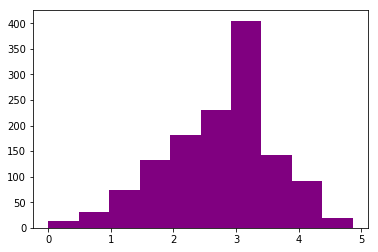

In [24]:
plt.hist(np.log(no_discount_df.Quantity), color='purple');

In [25]:
yes_discount_df = pd.read_sql_query('SELECT Quantity, Discount FROM OrderDetail WHERE Discount != 0.0', conn)
yes_discount_df.head()

,Quantity,Discount
0,35,0.15
1,15,0.15
2,6,0.05
3,15,0.05
4,40,0.05


In [26]:
yes_discount_df.describe()

,Quantity,Discount
count,838.000000,838.000000
mean,27.109785,0.144439
std,20.771439,0.071808
min,1.000000,0.010000
25%,12.000000,0.100000
50%,20.000000,0.150000
75%,36.000000,0.200000
max,130.000000,0.250000


#### Distribution of Quantity with Discount

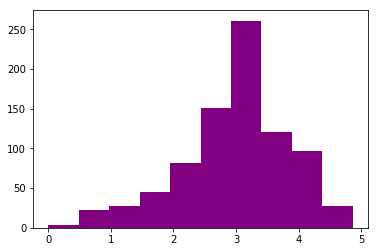

In [27]:
plt.hist(np.log(yes_discount_df.Quantity), color='purple');

In [28]:
mu1 = no_discount_df['Quantity'].mean()
std1 = no_discount_df['Quantity'].std(ddof=0)
print(f'No discount mean = {mu1}')
print(f'No discount standard deviation = {std1}')

No discount mean = 21.715261958997722
No discount standard deviation = 17.500845477669806


In [29]:
mu2 = yes_discount_df['Quantity'].mean()
std2 = yes_discount_df['Quantity'].std(ddof=0)
print(f'Yes discount mean = {mu2}')
print(f'Yes discount standard deviation = {std2}')

Yes discount mean = 27.10978520286396
Yes discount standard deviation = 20.759042075141373


In [30]:
t, p = stats.ttest_ind(no_discount_df['Quantity'], yes_discount_df['Quantity'])
# Divide this p-value by 2 since this is a one-tailed t-test
if p/2 < 0.05:
    print(f'With a p-value of {round(p,3)}, the null hypothesis can be rejected.')
else:
    print(f'With a p-value of {round(p,3)}, the null hypothesis cannot be rejected.')

With a p-value of 0.0, the null hypothesis can be rejected.


## Hypothesis 1 Conclusion
#### With a p-value of 0.0, the null hypothesis that discount does not have a statistically significant effect on the quantity of the product ordered can be rejected.

### Discount amount?

## Hypothesis 2
* H0 - The top employee does not sell more in dollars than the average employee.
* H2 - The top employee sells more in dollars than the average employee. 

### Hypothesis 2 Values
* H0: $\mu$ $\le$ 1628.13 
* HA: $\mu$ > 1628.13

In [31]:
# employee sales without discounts
employee_sales_df = pd.read_sql_query('SELECT EmployeeId, SUM(OrderDetail.Quantity * OrderDetail.UnitPrice) AS Total \
FROM [Order] INNER JOIN OrderDetail ON [Order].Id = OrderDetail.OrderId GROUP BY EmployeeId ORDER BY Total DESC', conn)
employee_sales_df

,EmployeeId,Total
0,4,250187.45
1,3,213051.30
2,1,202143.71
3,2,177749.26
4,7,141295.99
5,8,133301.03
6,9,82964.00
7,6,78198.10
8,5,75567.75


In [32]:
# test sql math skillz
example = pd.read_sql_query('SELECT * FROM OrderDetail WHERE Discount != 0.0 LIMIT 2;', conn)
example

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15


In [33]:
first_order = (42.4 * 35) - (42.4 * .15)
second_order = (16.8 * 15) - (16.8 * .15)
total_sum = first_order + second_order
print(first_order)
print(second_order)
print(total_sum)

1477.64
249.48
1727.1200000000001


In [34]:
first_math_example = pd.read_sql_query('SELECT Id, UnitPrice*Quantity-UnitPrice*Discount AS Total FROM OrderDetail \
WHERE Id = "10250/51";', conn)
first_math_example

,Id,Total
0,10250/51,1477.64


In [35]:
second_math_example = pd.read_sql_query('SELECT Id, UnitPrice*Quantity-UnitPrice*Discount AS Total FROM OrderDetail WHERE Id = \
"10250/65";', conn)
second_math_example

,Id,Total
0,10250/65,249.48


In [36]:
third_math_test = pd.read_sql_query('SELECT Id, SUM(UnitPrice*Quantity-UnitPrice*Discount) AS Total FROM OrderDetail \
WHERE Id = "10250/65" OR Id = "10250/51";', conn)
third_math_test

,Id,Total
0,10250/65,1727.12


In [37]:
# total sales with discounts applied
total_employee_sales_in_dollars = pd.read_sql_query('SELECT EmployeeId, SUM(UnitPrice*Quantity-UnitPrice*Discount) AS Total \
FROM [Order] INNER JOIN OrderDetail ON OrderDetail.OrderId = [Order].Id GROUP BY EmployeeId ORDER BY Total DESC;', conn)
total_employee_sales_in_dollars

,EmployeeId,Total
0,4,249536.3550
1,3,212652.6125
2,1,201763.0405
3,2,177431.4755
4,7,140868.0110
5,8,132962.2245
6,9,82771.5430
7,6,78006.7955
8,5,75352.9100


In [38]:
# each sale by OrderId
each_employee_sale = pd.read_sql_query('SELECT EmployeeId, OrderDetail.OrderId, SUM(UnitPrice*Quantity-UnitPrice*Discount)\
AS Total FROM [Order] INNER JOIN OrderDetail ON [Order].Id = OrderDetail.OrderId GROUP BY OrderDetail.OrderId;', conn)
each_employee_sale.head(15)

,EmployeeId,OrderId,Total
0,5,10248,440.000
1,6,10249,1863.400
2,4,10250,1804.120
3,3,10251,669.180
4,4,10252,3726.660
5,3,10253,1444.800
6,5,10254,621.780
7,9,10255,2490.500
8,3,10256,517.800
9,4,10257,1119.900


In [39]:
each_employee_sale.describe()

,EmployeeId,OrderId,Total
count,830.000000,830.000000,830.000000
mean,4.403614,10662.500000,1628.126467
std,2.499648,239.744656,1987.417677
min,1.000000,10248.000000,12.500000
25%,2.000000,10455.250000,479.850000
50%,4.000000,10662.500000,1011.190000
75%,7.000000,10869.750000,2022.822500
max,9.000000,11077.000000,17235.925000


In [40]:
average_employee_sale = round(each_employee_sale.Total.mean(), 2)
average_employee_sale

1628.13

In [41]:
number_9_sales = pd.read_sql_query('SELECT EmployeeId, OrderDetail.OrderId, SUM(UnitPrice*Quantity-UnitPrice*Discount)\
AS Total FROM [Order] INNER JOIN OrderDetail ON [Order].Id = OrderDetail.OrderId WHERE EmployeeId = 9 GROUP BY \
OrderDetail.OrderId ORDER BY Total DESC;', conn)
number_9_sales.head(15)

,EmployeeId,OrderId,Total
0,9,10889,11380.0000
1,9,11017,6750.0000
2,9,10687,6172.9000
3,9,10324,6139.7900
4,9,10893,5502.1100
5,9,10953,4670.3250
6,9,10745,4529.8000
7,9,10672,4184.1500
8,9,10255,2490.5000
9,9,10263,2454.1500


In [42]:
number_9_sales.describe()

,EmployeeId,OrderId,Total
count,43.0,43.000000,43.000000
mean,9.0,10725.418605,1924.919605
std,0.0,226.334270,2353.274319
min,9.0,10255.000000,12.500000
25%,9.0,10561.500000,418.550000
50%,9.0,10771.000000,1152.500000
75%,9.0,10899.000000,2053.401250
max,9.0,11058.000000,11380.000000


#### Distribution of All Employee Sales

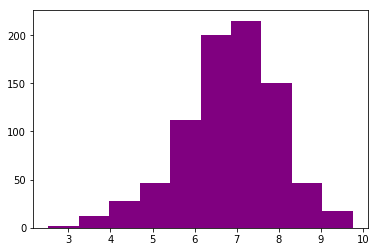

In [43]:
plt.hist(np.log(each_employee_sale.Total), color='purple');

#### Distribution of Employee 9's Sales

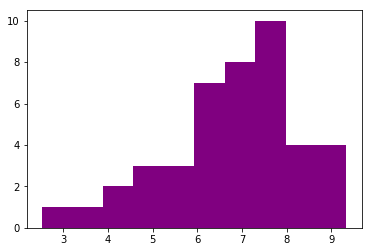

In [44]:
plt.hist(np.log(number_9_sales.Total), color='purple');

In [45]:
sample_mean = number_9_sales.Total.mean()
sample_std = number_9_sales.Total.std()

pop_mean = each_employee_sale.Total.mean()
pop_std = each_employee_sale.Total.std()

print(f'Sample mean: {sample_mean}')
print(f'Sample standard deviation: {sample_std}')
print(f'Population mean: {pop_mean}')
print(f'Population standard deviation: {pop_std}')

Sample mean: 1924.9196046511627
Sample standard deviation: 2353.274319183108
Population mean: 1628.1264668674696
Population standard deviation: 1987.4176772026924


In [46]:
t, p = stats.ttest_1samp(number_9_sales.Total, pop_mean)

print(f't-value: {t}')
print(f'p-value: {p/2}')

if p/2 < 0.05:
    print('With a p-value < 0.05, the null hypothesis can be rejected.')
else:
    print('With a p-value > 0.05, the null hypothesis cannot be rejected.')

t-value: 0.8270190770308689
p-value: 0.2064501814160421
With a p-value > 0.05, the null hypothesis cannot be rejected.


#### Confirm findings with critical t-value

In [47]:
d_freedom = len(number_9_sales.Total) - 1

t_crit = stats.t.ppf(1-0.05, df=d_freedom)
print(f'Critical t-value: {t_crit}')

if t > t_crit:
    print('Results are statistically significant with a t-value that is greater than the critical t-value.')
else:
    print('Results are not statistically significant if the t-value is less than the critical t-value.')

Critical t-value: 1.6819523559426
Results are not statistically significant if the t-value is less than the critical t-value.


## Hypothesis 2 Conclusion
#### With a p-value of 0.2 and a t-value that is less than the critical t-value, the null hypothesis that the top employee does not sell more than the average employee cannot be rejected.

## Hypothesis 3
* H0 - No product sells significantly better in quantity than the other products. (top product doesn't sell sig better)
* H3 - At least one product sells significantly better in quantity than the other products. 

### Hypothesis 3 Values
* H0: $\mu$ $\leq$ 23.8
* HA: $\mu$ > 23.8 

In [48]:
order_detail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [49]:
product_df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [50]:
product_df.describe()

,Id,SupplierId,CategoryId,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,39.000000,13.649351,4.116883,28.866364,40.506494,10.129870,12.467532,0.103896
std,22.371857,8.220267,2.395028,33.815111,36.147222,23.141072,10.931105,0.307127
min,1.000000,1.000000,1.000000,2.500000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,7.000000,2.000000,13.250000,15.000000,0.000000,0.000000,0.000000
50%,39.000000,13.000000,4.000000,19.500000,26.000000,0.000000,10.000000,0.000000
75%,58.000000,20.000000,6.000000,33.250000,61.000000,0.000000,25.000000,0.000000
max,77.000000,29.000000,8.000000,263.500000,125.000000,100.000000,30.000000,1.000000


In [51]:
order_detail_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [52]:
total_products_sold_df = pd.read_sql_query('SELECT ProductId, Product.ProductName, SUM(Quantity) as Total FROM \
OrderDetail INNER JOIN Product ON Product.Id = OrderDetail.ProductId GROUP BY ProductId ORDER BY Total DESC;', conn)
total_products_sold_df.head(10)

,ProductId,ProductName,Total
0,60,Camembert Pierrot,1577
1,59,Raclette Courdavault,1496
2,31,Gorgonzola Telino,1397
3,56,Gnocchi di nonna Alice,1263
4,16,Pavlova,1158
5,75,Rhönbräu Klosterbier,1155
6,24,Guaraná Fantástica,1125
7,40,Boston Crab Meat,1103
8,62,Tarte au sucre,1083
9,2,Chang,1057


In [53]:
total_products_sold_df.tail(10)

,ProductId,ProductName,Total
67,32,Mascarpone Fabioli,297
68,74,Longlife Tofu,297
69,73,Röd Kaviar,293
70,66,Louisiana Hot Spiced Okra,239
71,50,Valkoinen suklaa,235
72,67,Laughing Lumberjack Lager,184
73,48,Chocolade,138
74,37,Gravad lax,125
75,15,Genen Shouyu,122
76,9,Mishi Kobe Niku,95


In [54]:
camembert_sales = pd.read_sql_query('SELECT ProductName, OrderDetail.Quantity FROM Product INNER JOIN OrderDetail ON \
Product.Id = OrderDetail.ProductId WHERE Product.Id = 60;', conn)
camembert_sales.head()

,ProductName,Quantity
0,Camembert Pierrot,40
1,Camembert Pierrot,35
2,Camembert Pierrot,20
3,Camembert Pierrot,21
4,Camembert Pierrot,8


#### Distribution of Camembert Sales

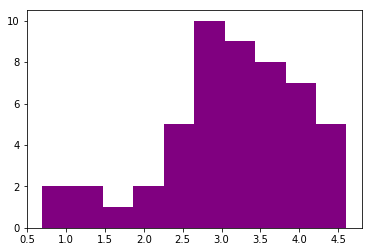

In [55]:
plt.hist(np.log(camembert_sales.Quantity), color='purple');

In [56]:
camembert_sales.describe()

,Quantity
count,51.000000
mean,30.921569
std,23.077992
min,2.000000
25%,15.000000
50%,24.000000
75%,42.500000
max,100.000000


In [57]:
all_sales = pd.read_sql_query('SELECT ProductId, Product.ProductName, OrderDetail.Quantity FROM OrderDetail INNER \
JOIN Product ON Product.Id = OrderDetail.ProductId ORDER BY OrderDetail.Quantity DESC;', conn)
all_sales.head()

,ProductId,ProductName,Quantity
0,39,Chartreuse verte,130
1,64,Wimmers gute Semmelknödel,130
2,55,Pâté chinois,120
3,55,Pâté chinois,120
4,27,Schoggi Schokolade,120


#### Distribution of All Sales

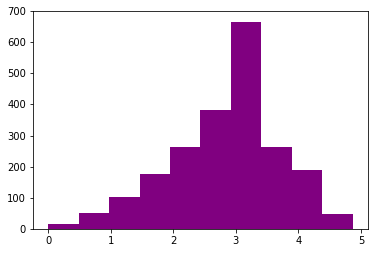

In [58]:
plt.hist(np.log(all_sales.Quantity), color='purple');

In [59]:
all_sales.describe()

,ProductId,Quantity
count,2155.000000,2155.000000
mean,40.793039,23.812993
std,22.159019,19.022047
min,1.000000,1.000000
25%,22.000000,10.000000
50%,41.000000,20.000000
75%,60.000000,30.000000
max,77.000000,130.000000


In [60]:
sample_mean = camembert_sales.Quantity.mean()
sample_std = camembert_sales.Quantity.std()

pop_mean = all_sales.Quantity.mean()
pop_std = all_sales.Quantity.std()

print(f'Sample mean: {sample_mean}')
print(f'Sample standard deviation: {sample_std}')
print(f'Population mean: {pop_mean}')
print(f'Population standard deviation: {pop_std}')

Sample mean: 30.92156862745098
Sample standard deviation: 23.07799223264875
Population mean: 23.812993039443157
Population standard deviation: 19.022046977493563


In [61]:
t, p = stats.ttest_1samp(camembert_sales.Quantity, pop_mean)
print(f't-value: {t}')
print(f'p-value: {p/2}')

if p < 0.05:
    print('With a p-value < 0.05, the null hypothesis can be rejected.')
else:
    print('With a p-value > 0.05, the null hypothesis cannot be rejected.')

t-value: 2.1997313838604335
p-value: 0.016238246947954497
With a p-value < 0.05, the null hypothesis can be rejected.


#### Confirm with critical t-value

In [62]:
d_freedom = len(camembert_sales) - 1
d_freedom

50

In [63]:
t_crit = stats.t.ppf(1-0.05, df=d_freedom)
print(f'Critical t-value: {t_crit}')

if t > t_crit:
    print('Results are statistically significant with a t-value that is greater than the critical t-value.')
else:
    print('Results are not statistically significant if the t-value is less than the critical t-value.')

Critical t-value: 1.6759050245283311
Results are statistically significant with a t-value that is greater than the critical t-value.


## Hypothesis 3 Conclusion
#### With a p-value of 0.016, the null hypothesis that all products sell equally well can be rejected. 

## Hypothesis 4
* H0 - No customer spent significantly more money per month than the average customer in 2013.
* H2 - One customer spent significantly more money per month than the average customer in 2013.

### Hypothesis 4 Values
* H0: 
* HA: 

In [135]:
customer_spending_jan_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS Jan_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", [Order].\
OrderDate) = "01" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY Jan_Total DESC;', conn)
customer_spending_jan_2013

,CustomerId,Jan_Total
0,MEREP,11446.160
1,SIMOB,11278.300
2,ERNSH,9496.745
3,BOTTM,4506.685
4,RATTC,3868.600
5,EASTC,3063.000
6,LAMAI,2594.800
7,RICSU,2205.200
8,QUEE,2010.770
9,WELLI,1886.960


In [136]:
customer_spending_feb_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS Feb_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", [Order].\
OrderDate) = "02" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY Feb_Total DESC;', conn)
customer_spending_feb_2013

,CustomerId,Feb_Total
0,SAVEA,7865.690
1,QUICK,4270.100
2,BLONP,4042.680
3,SUPRD,3891.000
4,WARTH,3077.000
5,KOENE,2236.400
6,VICTE,2211.580
7,LILAS,2039.625
8,ERNSH,1792.000
9,OLDWO,1755.000


In [114]:
customer_spending_march_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS March_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", \
[Order].OrderDate) = "03" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY \
March_Total DESC;', conn)
customer_spending_march_2013

,CustomerId,March_Total
0,RATTC,10495.600
1,HILAA,4616.640
2,VAFFE,2708.340
3,SUPRD,2478.400
4,FURIB,2139.815
5,WHITC,1821.730
6,BONAP,1820.800
7,LINOD,1754.560
8,BSBEV,1714.200
9,FRANK,1557.600


In [115]:
customer_spending_april_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS April_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", \
[Order].OrderDate) = "04" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY \
April_Total DESC;', conn)
customer_spending_april_2013

,CustomerId,April_Total
0,QUICK,10568.4750
1,ERNSH,8623.4500
2,SAVEA,4734.6650
3,HUNGO,4655.7850
4,TORTU,4150.0500
5,LEHMS,4025.9420
6,BONAP,2986.2000
7,WANDK,2413.4000
8,CHOPS,2352.7500
9,LILAS,1412.0000


In [116]:
customer_spending_may_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS May_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", \
[Order].OrderDate) = "05" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY \
May_Total DESC;', conn)
customer_spending_may_2013

,CustomerId,May_Total
0,QUICK,16027.8500
1,SEVES,4603.5350
2,PICCO,4180.0000
3,BERGS,3192.6500
4,WARTH,2881.9000
5,VICTE,2812.0000
6,LEHMS,2579.2300
7,FOLKO,2293.3500
8,ANTO,2145.1100
9,HANAR,2131.7450


In [117]:
customer_spending_june_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS June_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", \
[Order].OrderDate) = "06" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY \
June_Total DESC;', conn)
customer_spending_june_2013

,CustomerId,June_Total
0,SAVEA,3654.9100
1,MEREP,3299.2750
2,BLONP,3197.9675
3,HUNGO,3095.5000
4,FOLKO,2844.5000
5,WARTH,2403.4000
6,RATTC,2270.2250
7,MORGK,2147.4000
8,AROUT,2142.9000
9,ANTO,2082.0000


In [118]:
customer_spending_july_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS July_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", \
[Order].OrderDate) = "07" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY \
July_Total DESC;', conn)
customer_spending_july_2013

,CustomerId,July_Total
0,SAVEA,14357.4000
1,GREAL,6730.7500
2,ERNSH,6279.3750
3,MEREP,5458.9525
4,QUICK,3884.7000
5,LEHMS,3007.3135
6,HILAA,2642.4000
7,RATTC,2388.5000
8,WHITC,1458.1700
9,TRADH,1393.9400


In [120]:
customer_spending_aug_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS Aug_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", \
[Order].OrderDate) = "08" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY \
Aug_Total DESC;', conn)
customer_spending_aug_2013

,CustomerId,Aug_Total
0,ERNSH,6464.3705
1,FOLIG,4985.5000
2,MEREP,3957.5000
3,QUEE,2893.5375
4,GODOS,2775.0500
5,LINOD,2720.0500
6,HILAA,2054.0000
7,HUNGO,1907.1250
8,FAMIA,1818.5600
9,WANDK,1551.1750


In [121]:
customer_spending_sept_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS Sept_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", \
[Order].OrderDate) = "09" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY \
Sept_Total DESC;', conn)
customer_spending_sept_2013

,CustomerId,Sept_Total
0,SAVEA,9628.1000
1,HUNGO,6869.9000
2,FRANK,4923.1050
3,BERGS,4848.1050
4,RICSU,4666.9400
5,QUICK,4664.7300
6,BONAP,2027.7300
7,GREAL,1991.2100
8,ERNSH,1909.5000
9,OTTIK,1768.0000


In [122]:
customer_spending_oct_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS Oct_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", \
[Order].OrderDate) = "10" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY \
Oct_Total DESC;', conn)
customer_spending_oct_2013

,CustomerId,Oct_Total
0,QUICK,15961.3275
1,SAVEA,13795.7125
2,HUNGO,4592.5850
3,WHITC,3789.6825
4,ERNSH,3590.7880
5,VAFFE,3482.3400
6,KOENE,3463.0000
7,GOURL,3424.0000
8,FOLKO,2545.0000
9,OLDWO,1893.0000


In [119]:
customer_spending_nov_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS Nov_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", \
[Order].OrderDate) = "11" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY \
Nov_Total DESC;', conn)
customer_spending_nov_2013

,CustomerId,Nov_Total
0,SAVEA,5278.0000
1,QUICK,4529.8000
2,CHOPS,4298.5500
3,BONAP,3439.4500
4,RICSU,3341.3120
5,BOTTM,3118.0000
6,SPLIR,2461.5000
7,PICCO,1912.8500
8,WARTH,1858.0875
9,LINOD,1850.0000


In [123]:
customer_spending_dec_2013 = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) \
AS Dec_Total FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id WHERE strftime("%m", \
[Order].OrderDate) = "12" AND strftime("%Y", [Order].OrderDate) = "2013" GROUP BY [Order].CustomerId ORDER BY \
Dec_Total DESC;', conn)
customer_spending_dec_2013

,CustomerId,Dec_Total
0,ERNSH,14562.9500
1,FOLKO,5208.8750
2,FOLIG,4303.0000
3,BOLID,3995.1025
4,SEVES,3911.4050
5,SIMOB,3885.7025
6,LEHMS,3603.2200
7,MAISD,3289.0000
8,HILAA,2857.9840
9,THEBI,2775.0000


In [134]:
months = [customer_spending_jan_2013, customer_spending_feb_2013, customer_spending_march_2013, customer_spending_april_2013,
         customer_spending_may_2013, customer_spending_june_2013, customer_spending_july_2013, customer_spending_aug_2013,
         customer_spending_sept_2013, customer_spending_oct_2013, customer_spending_nov_2013, customer_spending_dec_2013]
for month in months:
    print(month.describe())

          Jan_Total
count     27.000000
mean    2464.664074
std     3200.924563
min       49.800000
25%      442.500000
50%     1622.400000
75%     2400.000000
max    11446.160000
         Feb_Total
count    21.000000
mean   1958.115000
std    1835.038867
min     408.900000
25%     631.600000
50%    1206.600000
75%    2236.400000
max    7865.690000
        March_Total
count     24.000000
mean    1663.366250
std     2147.907923
min      147.000000
25%      497.190000
50%     1150.060000
75%     1821.032500
max    10495.600000
        April_Total
count     27.000000
mean    2059.128130
std     2625.673889
min      147.900000
25%      318.900000
50%      894.880000
75%     2699.800000
max    10568.475000
          May_Total
count     26.000000
mean    2180.011635
std     3079.295292
min      110.000000
25%      556.787500
50%     1789.006250
75%     2507.760000
max    16027.850000
        June_Total
count    25.000000
mean   1559.100700
std    1074.483458
min     155.000000
25%     642.16

In [137]:
# anova table

## Exploration of the Data

In [31]:
order_df.dtypes

Id                  int64
CustomerId         object
EmployeeId          int64
OrderDate          object
RequiredDate       object
ShippedDate        object
ShipVia             int64
Freight           float64
ShipName           object
ShipAddress        object
ShipCity           object
ShipRegion         object
ShipPostalCode     object
ShipCountry        object
dtype: object

In [32]:
order_df['OrderDate'] = pd.to_datetime(order_df['OrderDate'])

In [33]:
order_df.dtypes

Id                         int64
CustomerId                object
EmployeeId                 int64
OrderDate         datetime64[ns]
RequiredDate              object
ShippedDate               object
ShipVia                    int64
Freight                  float64
ShipName                  object
ShipAddress               object
ShipCity                  object
ShipRegion                object
ShipPostalCode            object
ShipCountry               object
dtype: object

In [34]:
# order_df.OrderDate.values

The dataset includes products ordered in 2012, 2013, and 2014. 

In [35]:
category_df

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


Check out top customers

In [109]:
c.execute('SELECT CompanyName FROM Customer;').fetchall()

[('Alfreds Futterkiste',),
 ('Ana Trujillo Emparedados y helados',),
 ('Antonio Moreno Taquería',),
 ('Around the Horn',),
 ('Berglunds snabbköp',),
 ('Blauer See Delikatessen',),
 ('Blondesddsl père et fils',),
 ('Bólido Comidas preparadas',),
 ('Bon app',),
 ('Bottom-Dollar Markets',),
 ("B's Beverages",),
 ('Cactus Comidas para llevar',),
 ('Centro comercial Moctezuma',),
 ('Chop-suey Chinese',),
 ('Comércio Mineiro',),
 ('Consolidated Holdings',),
 ('Drachenblut Delikatessen',),
 ('Du monde entier',),
 ('Eastern Connection',),
 ('Ernst Handel',),
 ('Familia Arquibaldo',),
 ('FISSA Fabrica Inter. Salchichas S.A.',),
 ('Folies gourmandes',),
 ('Folk och fä HB',),
 ('Frankenversand',),
 ('France restauration',),
 ('Franchi S.p.A.',),
 ('Furia Bacalhau e Frutos do Mar',),
 ('Galería del gastrónomo',),
 ('Godos Cocina Típica',),
 ('Gourmet Lanchonetes',),
 ('Great Lakes Food Market',),
 ('GROSELLA-Restaurante',),
 ('Hanari Carnes',),
 ('HILARION-Abastos',),
 ('Hungry Coyote Import Store

In [111]:
# Find top orders
c.execute('SELECT OrderId, SUM(UnitPrice * Quantity) AS Total FROM OrderDetail GROUP BY OrderId ORDER BY Total DESC \
LIMIT 10;').fetchall()

[(10865, 17250.0),
 (11030, 16321.900000000001),
 (10981, 15810.0),
 (10372, 12281.2),
 (10424, 11493.2),
 (10817, 11490.7),
 (10889, 11380.0),
 (10417, 11283.2),
 (10897, 10835.240000000002),
 (10353, 10741.6)]

In [71]:
# c.execute('SELECT [Order].CustomerId, OrderId, SUM(UnitPrice * Quantity) as Total FROM OrderDetail INNER JOIN [Order] \
# ON OrderDetail.OrderId = [Order].Id GROUP BY OrderId ORDER BY Total DESC;').fetchall()

In [118]:
c.execute("SELECT CompanyName FROM Customer WHERE Id = 'QUICK';").fetchall()

[('QUICK-Stop',)]

In [69]:
# c.execute('SELECT OrderDate FROM [Order];').fetchall()

In [122]:
c.execute('SELECT OrderDate, CustomerId FROM [Order] WHERE CustomerId = "QUICK";').fetchall()

[('2012-08-05', 'QUICK'),
 ('2012-08-20', 'QUICK'),
 ('2012-08-21', 'QUICK'),
 ('2012-09-24', 'QUICK'),
 ('2012-11-04', 'QUICK'),
 ('2012-11-22', 'QUICK'),
 ('2013-01-17', 'QUICK'),
 ('2013-02-19', 'QUICK'),
 ('2013-04-23', 'QUICK'),
 ('2013-05-05', 'QUICK'),
 ('2013-05-19', 'QUICK'),
 ('2013-05-27', 'QUICK'),
 ('2013-07-03', 'QUICK'),
 ('2013-09-05', 'QUICK'),
 ('2013-10-03', 'QUICK'),
 ('2013-10-06', 'QUICK'),
 ('2013-10-29', 'QUICK'),
 ('2013-11-18', 'QUICK'),
 ('2013-12-04', 'QUICK'),
 ('2013-12-22', 'QUICK'),
 ('2014-01-21', 'QUICK'),
 ('2014-02-02', 'QUICK'),
 ('2014-02-10', 'QUICK'),
 ('2014-03-10', 'QUICK'),
 ('2014-03-19', 'QUICK'),
 ('2014-04-01', 'QUICK'),
 ('2014-04-02', 'QUICK'),
 ('2014-04-14', 'QUICK')]

In [123]:
c.execute('SELECT OrderDate, CustomerId FROM [Order] WHERE CustomerId = "LAZYK";').fetchall()

[('2013-03-21', 'LAZYK'), ('2013-05-22', 'LAZYK')]

In [126]:
customer_total_spent = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice * Quantity) as Total FROM OrderDetail INNER JOIN [Order] \
ON OrderDetail.OrderId = [Order].Id GROUP BY [Order].CustomerId ORDER BY Total DESC;', conn)
customer_total_spent.head(15)

,CustomerId,Total
0,QUICK,117483.39
1,SAVEA,115673.39
2,ERNSH,113236.68
3,HUNGO,57317.39
4,RATTC,52245.90
5,HANAR,34101.15
6,FOLKO,32555.55
7,MEREP,32203.90
8,KOENE,31745.75
9,QUEE,30226.10


Try to search by year

In [67]:
# c.execute('SELECT strftime("%Y", OrderDate) AS Year FROM [Order] WHERE Year = "2012";').fetchall()

In [75]:
c.execute('SELECT strftime("%Y", OrderDate) AS Year FROM [Order] ORDER BY Year DESC;').fetchall()

[('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2014',),
 ('2

In [72]:
# Search for top orders by customer and total price of order - try to find out how long the customer has been with the company
top_customer_orders = pd.read_sql_query('SELECT [Order].CustomerId, SUM(UnitPrice*Quantity-UnitPrice*Discount) AS Total \
FROM OrderDetail INNER JOIN [Order] ON OrderDetail.OrderId = [Order].Id GROUP BY OrderDetail.OrderId ORDER BY Total DESC;', conn)
top_customer_orders.head(20)

,CustomerId,Total
0,QUICK,17235.9250
1,SAVEA,16272.4525
2,HANAR,15810.0000
3,QUEE,12198.5500
4,KOENE,11475.8605
5,MEREP,11446.1600
6,RATTC,11380.0000
7,SIMOB,11278.3000
8,HUNGO,10835.2400
9,PICCO,10696.0800


In [87]:
# Try to find customers that have been with company since 2012
early_customers = pd.read_sql_query('SELECT DISTINCT CustomerId, strftime("%Y", OrderDate) AS Year FROM [Order] WHERE Year = "2012";', conn)
early_customers

,CustomerId,Year
0,VINET,2012
1,TOMSP,2012
2,HANAR,2012
3,VICTE,2012
4,SUPRD,2012
5,CHOPS,2012
6,RICSU,2012
7,WELLI,2012
8,HILAA,2012
9,ERNSH,2012


In [79]:
len(three_year_customers.CustomerId.unique())

89

In [82]:
from collections import defaultdict

In [83]:
d = defaultdict(list)

In [84]:
for c,y in zip(three_year_customers.CustomerId, three_year_customers.Year):
    d[c].append(y)
    
d

defaultdict(list,
            {'ALFKI': ['2014'],
             'ANATR': ['2014'],
             'ANTO': ['2014'],
             'AROUT': ['2014'],
             'BERGS': ['2014'],
             'BLAUS': ['2014'],
             'BLONP': ['2014'],
             'BOLID': ['2014'],
             'BONAP': ['2014'],
             'BOTTM': ['2014'],
             'BSBEV': ['2014'],
             'CACTU': ['2014'],
             'CENTC': ['2012'],
             'CHOPS': ['2014'],
             'COMMI': ['2014'],
             'CONSH': ['2014'],
             'DRACD': ['2014'],
             'DUMO': ['2014'],
             'EASTC': ['2014'],
             'ERNSH': ['2014'],
             'FAMIA': ['2013'],
             'FOLIG': ['2013'],
             'FOLKO': ['2014'],
             'FRANK': ['2014'],
             'FRANR': ['2014'],
             'FRANS': ['2014'],
             'FURIB': ['2014'],
             'GALED': ['2014'],
             'GODOS': ['2014'],
             'GOURL': ['2014'],
             'GREAL': ['